In [1]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
import itertools
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

## Список литературы:
* 1) https://onlinelibrary.wiley.com/doi/abs/10.1111/exsy.12649
* 2) https://www.statology.org/dickey-fuller-test-python/
* 3) https://www.researchgate.net/profile/Robert-Elliott-13/publication/227624374_Pairs_Trading/links/552cd4a10cf29b22c9c471b8/Pairs-Trading.pdf
* 4) https://xplaind.com/714828/beta-coefficient
* 5) https://blog.quantinsti.com/pairs-trading-basics/

## Обработка данных

In [2]:
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='max')

In [3]:
sp500[:5]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0
1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0
1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0
1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0


In [4]:
sp500['daily_return'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In [5]:
sp500 = sp500.reset_index()

In [6]:
sp500[:5]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0,NaN
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0,0.011340
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0,0.004737
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0,0.002949
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0,0.005872


In [7]:
df_stock = pd.read_csv('stock_data.csv')

In [8]:
ticker_info = pd.read_csv('ticker_info.csv')

In [9]:
df_stock[:5]

,date,ticker,open,high,low,close,volume,outstanding_share,turnover,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_mv,qfq_factor
0,2005-01-04,sh600000,0.77,0.77,0.75,0.76,3808939.0,900000000.0,0.004232,17.1990,14.4219,2.0777,3.1439,2.2097,6.9549,6.9549,2693520.0,8.895254
1,2005-01-05,sh600000,0.76,0.76,0.74,0.75,5225244.0,900000000.0,0.005806,16.9240,14.1913,2.0445,3.0937,2.1744,7.0679,7.0679,2650455.0,8.895254
2,2005-01-06,sh600000,0.75,0.75,0.73,0.74,4298099.0,900000000.0,0.004776,16.6991,14.0026,2.0173,3.0525,2.1455,7.1632,7.1632,2615220.0,8.895254
3,2005-01-07,sh600000,0.74,0.75,0.73,0.74,4362864.0,900000000.0,0.004848,16.7491,14.0446,2.0233,3.0617,2.1519,7.1418,7.1418,2623050.0,8.895254
4,2005-01-10,sh600000,0.75,0.77,0.74,0.77,7115260.0,900000000.0,0.007906,17.3240,14.0575,2.0082,3.1668,2.2258,6.9048,6.9048,2713095.0,8.895254


In [10]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129344 entries, 0 to 10129343
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date               object 
 1   ticker             object 
 2   open               float64
 3   high               float64
 4   low                float64
 5   close              float64
 6   volume             float64
 7   outstanding_share  float64
 8   turnover           float64
 9   pe                 float64
 10  pe_ttm             float64
 11  pb                 float64
 12  ps                 float64
 13  ps_ttm             float64
 14  dv_ratio           float64
 15  dv_ttm             float64
 16  total_mv           float64
 17  qfq_factor         float64
dtypes: float64(16), object(2)
memory usage: 1.4+ GB


In [11]:
df_stock.isna().sum()

date                       0
ticker                     0
open                       0
high                       0
low                        0
close                      0
volume                     0
outstanding_share          0
turnover                   0
pe                    933946
pe_ttm               1336380
pb                     94050
ps                      5289
ps_ttm                 10726
dv_ratio             1463360
dv_ttm               3660488
total_mv                  26
qfq_factor                 0
dtype: int64

In [12]:
df_stock.date = pd.to_datetime(df_stock.date)

In [13]:
sp500.Date = pd.to_datetime(sp500.Date)

In [14]:
df_stock['daily_return'] = np.log(
    df_stock['close'] / df_stock['close'].shift(1))

In [15]:
df = df_stock.groupby('ticker')['date'].agg(['min']).reset_index()
df_stock = df_stock[df_stock.ticker.isin(df[df['min'] <= '2011-01-01'].ticker)]
df_stock = df_stock[df_stock.date >= '2011-01-01']

In [16]:
df = df_stock.groupby('ticker')['date'].agg(['min']).reset_index()

In [17]:
df_stock = df_stock[df_stock.ticker.isin(df['ticker'][df['min'] == df_stock.groupby(
    'ticker')['date'].agg('min').sort_values()[0]])]

In [18]:
ticker_info = ticker_info[ticker_info['ticker'].isin(
    df[df['min'] <= '2011-01-01'].ticker)]

In [19]:
df_stock = df_stock.reset_index(drop=True)

In [20]:
ticker_info = ticker_info.reset_index(drop=True)

In [21]:
df_prices = df_stock.pivot(
    index='date', columns='ticker', values='open').reset_index()

In [22]:
df_prices[:5]

ticker,date,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,...,sz300145,sz300146,sz300147,sz300148,sz300149,sz300150,sz300151,sz300152,sz300153,sz300154
0,2011-01-04,4.46,4.53,4.34,8.47,2.57,10.45,1.34,3.85,3.98,...,1.98,5.04,6.93,4.67,5.34,10.00,4.52,7.39,8.98,8.25
1,2011-01-05,4.56,4.61,4.39,8.65,2.56,10.41,1.36,3.79,3.95,...,2.00,4.99,6.91,4.72,5.44,10.24,4.61,7.88,9.10,8.16
2,2011-01-06,4.57,4.75,4.40,8.57,2.60,10.95,1.35,3.78,4.04,...,2.03,4.82,6.94,4.72,5.38,10.72,4.60,7.93,8.92,8.58
3,2011-01-07,4.56,4.62,4.42,8.59,2.56,11.06,1.34,3.77,4.02,...,2.00,4.83,6.94,4.55,5.33,10.93,4.48,7.46,9.03,8.61
4,2011-01-10,4.71,4.57,4.43,8.52,2.57,10.98,1.35,3.76,4.05,...,1.99,4.72,6.73,4.64,5.36,10.66,4.37,7.03,8.84,8.29


In [23]:
df_prices = df_prices.ffill()

In [24]:
df_prices.isnull().sum().sort_values()

ticker
date        0
sz002036    0
sz002035    0
sz002034    0
sz002033    0
           ..
sh600793    0
sh600792    0
sh600791    0
sh600804    0
sz300154    0
Length: 1905, dtype: int64

In [25]:
df_prices[(df_prices['date'] >= '2011-04-20') &
          (df_prices['date'] <= '2011-04-30')]

ticker,date,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,...,sz300145,sz300146,sz300147,sz300148,sz300149,sz300150,sz300151,sz300152,sz300153,sz300154
69,2011-04-20,5.24,4.53,4.74,8.52,2.57,12.76,3.00,3.92,4.16,...,1.83,3.51,6.31,3.90,4.58,6.78,3.66,5.05,8.16,7.50
70,2011-04-21,5.25,4.56,4.78,9.08,2.60,12.81,2.88,3.96,4.21,...,1.85,3.56,6.40,3.94,4.39,6.88,3.70,5.10,8.00,7.46
71,2011-04-22,5.22,4.59,4.75,9.26,2.64,12.70,2.92,3.98,4.21,...,1.84,3.65,6.48,3.93,4.42,6.91,3.71,5.10,8.00,7.41
72,2011-04-25,5.23,4.62,4.79,8.83,2.64,12.37,2.73,4.07,4.17,...,1.83,3.68,6.31,3.74,4.42,6.96,3.73,5.02,7.65,7.35
73,2011-04-26,5.23,4.52,4.79,8.47,2.56,12.08,2.73,4.00,4.13,...,1.82,3.61,6.14,3.59,4.32,6.99,3.48,4.65,7.24,7.06
74,2011-04-27,5.32,4.48,4.68,8.51,2.53,12.16,2.76,3.89,4.14,...,1.76,3.55,5.93,3.50,4.11,7.21,3.40,4.66,7.06,6.90
75,2011-04-28,5.32,4.45,4.59,8.24,2.52,11.87,2.60,3.95,4.17,...,1.75,3.49,5.88,3.48,4.08,6.87,3.40,4.34,7.04,6.80
76,2011-04-29,5.28,4.37,4.44,7.86,2.47,11.85,2.60,3.90,4.17,...,1.75,3.36,5.71,3.37,4.02,6.52,3.16,4.13,6.92,6.84


## Расчет Beta-коэффициента

Стратегия представлена в [1]. Стратегия заключается в использовании феномена корреляции стоимости некоторых ценных бумаг (парный трейдинг). Как указано в [1], необходимо для начала определить коэффициент бета (формула коэффициента бета представлена также в [4]), который определяет степень "агрессивности" (насколько более чувствительно реагирует акция на основные рыночные тенденции и есть ли в данной бумаге внутренняя идея, способная игнорировать общерыночные тенденции, которые охватывают своим движением большинство бумаг на рынке) акции относительно маркет-индекса. Для сравнения был выбран индекс S&P500.

In [26]:
df_stock_T = df_stock.pivot(index='date', columns='ticker', values='daily_return').reset_index()
df_sp=df_stock_T.merge(sp500[['Date','daily_return']],left_on='date',right_on='Date')

In [27]:
df_sp = df_sp.drop(columns=['Date'])

In [28]:
df_sp = df_sp.apply(lambda x: x.fillna(x.mean()),axis=0)

In [29]:
df_sp

,date,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,...,sz300146,sz300147,sz300148,sz300149,sz300150,sz300151,sz300152,sz300153,sz300154,daily_return
0,2011-01-04,0.017818,0.019673,0.016037,0.028138,0.011742,-0.001919,0.029632,-0.020673,0.000000,...,0.001990,0.008633,0.023380,0.037110,0.041182,0.032790,0.077159,0.018837,0.041673,-0.001314
1,2011-01-05,0.006601,0.027750,0.000000,-0.013970,0.015444,0.056945,-0.022141,-0.013141,0.015038,...,-0.040574,-0.002869,-0.010560,-0.014679,0.041398,-0.006473,-0.021264,-0.009928,0.019026,0.004995
2,2011-01-06,-0.002195,-0.023430,0.006795,0.005845,-0.011561,0.006332,0.000000,-0.002649,0.000000,...,0.008247,0.001436,-0.036761,-0.016776,0.023681,-0.028542,-0.063949,0.003320,0.029021,-0.002125
3,2011-01-07,0.043017,-0.015201,0.004505,-0.004673,-0.007782,-0.013618,0.007435,0.000000,0.004963,...,-0.024949,-0.027638,0.019630,0.013072,-0.027374,-0.020248,-0.045494,-0.018963,-0.049248,-0.001846
4,2011-01-10,-0.012712,-0.011001,-0.025030,-0.045517,-0.023717,-0.030629,-0.030077,-0.016043,-0.027605,...,-0.072005,-0.019360,-0.021835,-0.039740,-0.059065,0.004535,-0.031521,0.000000,-0.010876,-0.001377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2022-05-05,-0.004994,0.016584,0.025533,-0.009158,0.000000,0.037740,-0.010695,-0.024967,0.000000,...,0.008929,0.085195,-0.006452,0.059300,0.008163,0.048367,0.013158,0.024550,0.003891,-0.036301
2662,2022-05-06,-0.017677,-0.064539,-0.025533,-0.027261,-0.027780,-0.062124,-0.032790,-0.045985,-0.009743,...,-0.039794,-0.028742,-0.013030,-0.005063,-0.008163,-0.022033,-0.016475,0.012757,-0.013685,-0.005690
2663,2022-05-09,-0.003829,-0.013245,0.000000,0.095641,0.031198,-0.020114,0.021979,0.027558,0.005579,...,0.011242,0.020374,0.025891,0.006073,0.024293,0.002472,0.029462,0.005618,0.015625,-0.032562
2664,2022-05-10,0.003829,0.000000,0.017094,0.050897,0.016921,-0.002755,0.005420,0.043394,-0.008380,...,-0.000508,0.000000,0.006369,0.009041,0.018495,0.029798,0.012821,0.009756,0.019194,0.002455


In [30]:
cov = df_sp.drop(columns='date').cov()

In [31]:
(cov.loc['daily_return']/df_sp['daily_return'].var()).sort_values(ascending=False)

daily_return    1.000000
sz300033        0.334855
sz002460        0.319412
sz300097        0.318204
sz300002        0.314907
                  ...   
sz002030       -0.014564
sz000520       -0.024001
sz000721       -0.052557
sh600890       -0.062268
sh600448       -0.068097
Name: daily_return, Length: 1905, dtype: float64

Полученные результаты свидетельствуют о том, что коэффициент бета для всех акций меньше 1

## Группировка данных в соответствии с заданием

обучающая выборка: 2011 год или более ранний (на Ваше усмотрение)  — последний торговый день 2020 года,
тестовая выборка: первый торговый день 2021 года - последний торговый день 2021 года,
выборка для финального расчёта результатов модели: первый торговый день 2022 года - 11 мая 2022 года

In [32]:
df_train = df_prices[(df_prices.date>='2011-01-01') & (df_prices.date<'2021-01-01')]

In [33]:
df_test = df_prices[(df_prices.date>='2021-01-01') & (df_prices.date<'2022-01-01')]

In [34]:
df_res = df_prices[(df_prices.date>='2022-01-01')]

## Тест на стационарность данных

* H0: временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.
* HA: временной ряд является стационарным.

Если статистика теста (p-значения) значима при уровне 1% (или меньше) в тесте на стационарность, мы можем отклонить нулевую гипотезу.

In [35]:
df_prices[:5]

ticker,date,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,...,sz300145,sz300146,sz300147,sz300148,sz300149,sz300150,sz300151,sz300152,sz300153,sz300154
0,2011-01-04,4.46,4.53,4.34,8.47,2.57,10.45,1.34,3.85,3.98,...,1.98,5.04,6.93,4.67,5.34,10.00,4.52,7.39,8.98,8.25
1,2011-01-05,4.56,4.61,4.39,8.65,2.56,10.41,1.36,3.79,3.95,...,2.00,4.99,6.91,4.72,5.44,10.24,4.61,7.88,9.10,8.16
2,2011-01-06,4.57,4.75,4.40,8.57,2.60,10.95,1.35,3.78,4.04,...,2.03,4.82,6.94,4.72,5.38,10.72,4.60,7.93,8.92,8.58
3,2011-01-07,4.56,4.62,4.42,8.59,2.56,11.06,1.34,3.77,4.02,...,2.00,4.83,6.94,4.55,5.33,10.93,4.48,7.46,9.03,8.61
4,2011-01-10,4.71,4.57,4.43,8.52,2.57,10.98,1.35,3.76,4.05,...,1.99,4.72,6.73,4.64,5.36,10.66,4.37,7.03,8.84,8.29


In [36]:
adf_results = {}
for col in df_train.columns.values[1:]:  
    adf_results[col] = adfuller(df_train[col])

In [37]:
adf_df=pd.DataFrame(adf_results).T.reset_index()
adf_df.columns=['ticker','test_statistic','p_value','used_lag','nobs','Critical(1%,5%,10%)','icbest']

In [38]:
adf_df[:5]

,ticker,test_statistic,p_value,used_lag,nobs,"Critical(1%,5%,10%)",icbest
0,sh600000,-1.357798,0.602333,15,2416,"{'1%': -3.43305954530467, '5%': -2.86273704443...",-2848.004089
1,sh600004,-1.12017,0.706962,15,2416,"{'1%': -3.43305954530467, '5%': -2.86273704443...",119.426816
2,sh600006,-1.547581,0.509856,27,2404,"{'1%': -3.4330730849724276, '5%': -2.862743023...",-636.04943
3,sh600007,-2.096962,0.245738,2,2429,"{'1%': -3.4330450284586047, '5%': -2.862730633...",1083.96871
4,sh600008,-2.226887,0.196632,27,2404,"{'1%': -3.4330730849724276, '5%': -2.862743023...",-3599.204386


In [39]:
adf_df50 = adf_df.sort_values(by='p_value',ascending=False)[:50]

In [40]:
df_spread_all=pd.DataFrame()
df_spread_all['date']=df_prices['date']
comb = list(itertools.combinations(adf_df50['ticker'], 2))
for i in range(len(comb)):
    df_spread_all[str(comb[i][0])+'-'+str(comb[i][1])]=df_prices[comb[i][0]]-df_prices[comb[i][1]]

C:\Users\pda95\AppData\Local\Temp/ipykernel_1012/4284634659.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [41]:
df_train_spread=pd.DataFrame()
df_train_spread['date']=df_train['date']
comb = list(itertools.combinations(adf_df50['ticker'], 2))
for i in range(len(comb)):
    df_train_spread[str(comb[i][0])+'-'+str(comb[i][1])]=df_train[comb[i][0]]-df_train[comb[i][1]]

C:\Users\pda95\AppData\Local\Temp/ipykernel_1012/2589539585.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [42]:
df_test_spread=pd.DataFrame()
df_test_spread['date']=df_test['date']
comb = list(itertools.combinations(adf_df50['ticker'], 2))
for i in range(len(comb)):
    df_test_spread[str(comb[i][0])+'-'+str(comb[i][1])]=df_test[comb[i][0]]-df_test[comb[i][1]]

C:\Users\pda95\AppData\Local\Temp/ipykernel_1012/4110781426.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [43]:
df_res_spread=pd.DataFrame()
df_res_spread['date']=df_res['date']
comb = list(itertools.combinations(adf_df50['ticker'], 2))
for i in range(len(comb)):
    df_res_spread[str(comb[i][0])+'-'+str(comb[i][1])]=df_res[comb[i][0]]-df_res[comb[i][1]]

C:\Users\pda95\AppData\Local\Temp/ipykernel_1012/656190601.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [44]:
adf_spreads = {}
for col in df_train_spread.columns.values[1:]:  
    adf_spreads[col] = adfuller(df_train_spread[col])

In [45]:
adf_spreads_df=pd.DataFrame(adf_spreads).T.reset_index()
adf_spreads_df.columns=['ticker','test_statistic','p_value','used_lag','nobs','Critical(1%,5%,10%)','icbest']

In [46]:
adf_less_1pc = adf_spreads_df[['ticker','p_value']][adf_spreads_df['p_value']<0.01].sort_values(by='p_value').ticker

In [47]:
adf_spreads_df[['ticker', 'p_value']][adf_spreads_df['p_value']
                                      < 0.01].sort_values(by='p_value')

,ticker,p_value
147,sz000858-sz000596,0.000097
339,sz000596-sh601888,0.000262
1082,sz300087-sz300138,0.000272
459,sh600763-sh601888,0.000502
765,sh600436-sh601888,0.000784
903,sz002475-sz002311,0.001547
608,sz300015-sz002311,0.002086
1137,sz002410-sh600872,0.002104
1063,sz300012-sz002414,0.002254
46,sz300037-sz000733,0.002332


In [48]:
adf_less_1pc.str.split('-').to_list()

[['sz000858', 'sz000596'],
 ['sz000596', 'sh601888'],
 ['sz300087', 'sz300138'],
 ['sh600763', 'sh601888'],
 ['sh600436', 'sh601888'],
 ['sz002475', 'sz002311'],
 ['sz300015', 'sz002311'],
 ['sz002410', 'sh600872'],
 ['sz300012', 'sz002414'],
 ['sz300037', 'sz000733'],
 ['sz002311', 'sz002410'],
 ['sh600809', 'sh601888'],
 ['sz002410', 'sh600600'],
 ['sz000858', 'sh601888'],
 ['sz002475', 'sh600600'],
 ['sz300124', 'sz002025'],
 ['sz000860', 'sh600872'],
 ['sh600309', 'sh600872']]

In [49]:
cointegration_prices = {}
for i in range(len(adf_less_1pc)):
    cointegration_prices[tuple(adf_less_1pc.str.split('-').to_list()[i])] = coint(
        df_train[adf_less_1pc.str.split('-').to_list()[i][0]], df_train[adf_less_1pc.str.split('-').to_list()[i][1]])

In [50]:
coint_df = pd.DataFrame(cointegration_prices).T.reset_index()
coint_df.columns = ['ticker1', 'ticker2',
                    'test_statistic', 'p_value', 'Critical(1%,5%,10%)']
coint_df[['1%', '5%', '10%']] = pd.DataFrame(
    coint_df['Critical(1%,5%,10%)'].tolist(), index=coint_df.index)
coint_df = coint_df.drop(columns=['Critical(1%,5%,10%)'])
coint_df[coint_df.test_statistic < coint_df['1%']].sort_values(
    by='test_statistic').reset_index(drop=True)

,ticker1,ticker2,test_statistic,p_value,1%,5%,10%
0,sz000858,sz000596,-6.368732,0.0,-3.900951,-3.338645,-3.046195
1,sz300015,sz002311,-5.428118,0.000025,-3.900951,-3.338645,-3.046195
2,sz000858,sh601888,-4.627665,0.00075,-3.900951,-3.338645,-3.046195
3,sz000596,sh601888,-4.53365,0.001078,-3.900951,-3.338645,-3.046195
4,sh600763,sh601888,-4.369711,0.001989,-3.900951,-3.338645,-3.046195
5,sh600436,sh601888,-4.367269,0.002007,-3.900951,-3.338645,-3.046195
6,sz002311,sz002410,-4.120003,0.004807,-3.900951,-3.338645,-3.046195
7,sz002410,sh600872,-4.075904,0.005581,-3.900951,-3.338645,-3.046195
8,sz300087,sz300138,-4.007387,0.007009,-3.900951,-3.338645,-3.046195
9,sz002475,sz002311,-3.973985,0.007819,-3.900951,-3.338645,-3.046195


На основе полученных результатов, выбираем следующую пару акций (в соответствии со стратегией, представленной в [1]): sz000858 и sz000596

## Использование LSTM-нейросети для предсказания цены акций и спрэда

### Акция sz000858

In [51]:
scaler=MinMaxScaler(feature_range=(0,1))

In [52]:
scaled_sz000858 = scaler.fit_transform(df_train.filter(['sz000858']).values)

In [53]:
train_data_sz000858 = scaled_sz000858[0:len(scaled_sz000858),:]
x_train = []
y_train = []

In [54]:
window = 60
for i in range(window ,len(train_data_sz000858)):
    x_train.append(train_data_sz000858[i-window:i,0])
    y_train.append(train_data_sz000858[i,0])

In [55]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [56]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2372, 60, 1)

In [57]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [58]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [59]:
model.fit(x_train,y_train,batch_size=32,epochs=100)

Epoch 1/100
75/75 [==============================] - 3s 21ms/step - loss: 0.0020
Epoch 2/100
75/75 [==============================] - 2s 21ms/step - loss: 2.3556e-04
Epoch 3/100
75/75 [==============================] - 2s 21ms/step - loss: 2.3145e-04
Epoch 4/100
75/75 [==============================] - 2s 22ms/step - loss: 2.3240e-04
Epoch 5/100
75/75 [==============================] - 2s 22ms/step - loss: 2.6226e-04
Epoch 6/100
75/75 [==============================] - 2s 23ms/step - loss: 2.2055e-04
Epoch 7/100
75/75 [==============================] - 2s 21ms/step - loss: 2.1323e-04
Epoch 8/100
75/75 [==============================] - 2s 21ms/step - loss: 1.8810e-04
Epoch 9/100
75/75 [==============================] - 2s 22ms/step - loss: 1.9365e-04
Epoch 10/100
75/75 [==============================] - 2s 21ms/step - loss: 2.1013e-04
Epoch 11/100
75/75 [==============================] - 2s 21ms/step - loss: 1.7276e-04
Epoch 12/100
75/75 [==============================] - 2s 21ms/step 

In [60]:
scaled_sz000858_test = scaler.fit_transform(df_test.filter(['sz000858']).values)
scaled_sz000596_test = scaler.fit_transform(df_test.filter(['sz000596']).values)

In [61]:
test_data_sz000858 = scaled_sz000858_test[0:len(scaled_sz000858_test),:]
x_test = []
y_test = []

In [62]:
window = 60
for i in range(window ,len(test_data_sz000858)):
    x_test.append(test_data_sz000858[i-window:i,0])
    y_test.append(test_data_sz000858[i,0])

In [63]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [64]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [65]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 0s 10ms/step


In [66]:
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

218.3526006937466

In [67]:
train_plot = df_train.filter(['sz000858'])
test_plot = df_test.filter(['sz000858'])[:60]
valid = df_test.filter(['sz000858'])[60:]
valid['Predictions'] = predictions

In [68]:
valid = pd.merge(valid, df_test['date'], left_index=True, right_index=True)

In [69]:
df_train[['date','sz000858']]

ticker,date,sz000858
0,2011-01-04,28.00
1,2011-01-05,27.63
2,2011-01-06,27.01
3,2011-01-07,26.89
4,2011-01-10,26.71
...,...,...
2427,2020-12-25,269.99
2428,2020-12-28,273.36
2429,2020-12-29,283.34
2430,2020-12-30,280.19


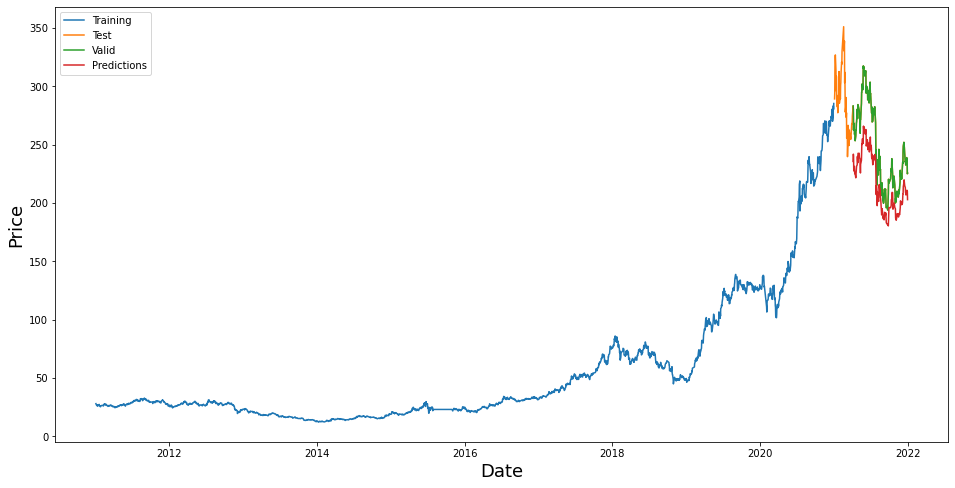

In [70]:
plt.figure(figsize=(16,8))
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(df_train['date'],df_train['sz000858'])
plt.plot(df_test['date'],df_test['sz000858'])
plt.plot(valid['date'],valid[['sz000858','Predictions']])
plt.legend(['Training', 'Test', 'Valid', 'Predictions'])

### Акция sz000596

In [71]:
scaled_sz000596 = scaler.fit_transform(df_train.filter(['sz000596']).values)

In [72]:
train_data_sz000596 = scaled_sz000596[0:len(scaled_sz000596),:]

In [73]:
x_train = []
y_train = []

In [74]:
window = 60
for i in range(window ,len(train_data_sz000596)):
    x_train.append(train_data_sz000596[i-window:i,0])
    y_train.append(train_data_sz000596[i,0])

In [75]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2372, 60, 1)

In [76]:
model.fit(x_train,y_train,batch_size=32,epochs=100)

Epoch 1/100
75/75 [==============================] - 2s 25ms/step - loss: 1.0236e-04
Epoch 2/100
75/75 [==============================] - 2s 24ms/step - loss: 1.0653e-04
Epoch 3/100
75/75 [==============================] - 2s 24ms/step - loss: 9.9763e-05
Epoch 4/100
75/75 [==============================] - 2s 23ms/step - loss: 1.0241e-04
Epoch 5/100
75/75 [==============================] - 2s 23ms/step - loss: 9.1991e-05
Epoch 6/100
75/75 [==============================] - 2s 22ms/step - loss: 9.2362e-05
Epoch 7/100
75/75 [==============================] - 2s 22ms/step - loss: 1.0003e-04
Epoch 8/100
75/75 [==============================] - 2s 22ms/step - loss: 1.0250e-04
Epoch 9/100
75/75 [==============================] - 2s 24ms/step - loss: 1.0386e-04
Epoch 10/100
75/75 [==============================] - 2s 23ms/step - loss: 9.2655e-05
Epoch 11/100
75/75 [==============================] - 2s 23ms/step - loss: 1.0911e-04
Epoch 12/100
75/75 [==============================] - 2s 25ms/s

In [77]:
scaled_sz000596_test = scaler.fit_transform(df_test.filter(['sz000596']).values)

In [78]:
test_data_sz000596 = scaled_sz000596_test[0:len(scaled_sz000596_test),:]

In [79]:
x_test = []
y_test = []

In [80]:
window = 60
for i in range(window ,len(test_data_sz000596)):
    x_test.append(test_data_sz000596[i-window:i,0])
    y_test.append(test_data_sz000596[i,0])

In [81]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [82]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 0s 8ms/step


In [83]:
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

231.1892532682061

In [84]:
train_plot = df_train.filter(['sz000596'])
test_plot = df_test.filter(['sz000596'])[:60]
valid = df_test.filter(['sz000596'])[60:]
valid['Predictions'] = predictions

In [85]:
valid = pd.merge(valid, df_test['date'], left_index=True, right_index=True)

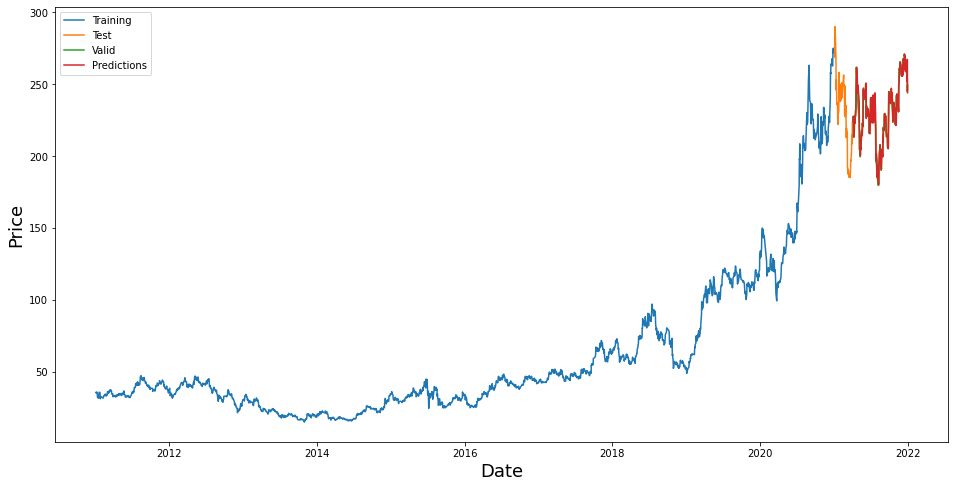

In [86]:
plt.figure(figsize=(16,8))
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(df_train['date'],df_train['sz000596'])
plt.plot(df_test['date'],df_test['sz000596'])
plt.plot(valid['date'],valid[['sz000596','Predictions']])
plt.legend(['Training', 'Test', 'Valid', 'Predictions'])

### Спред между акциями

In [87]:
scaled_spread = scaler.fit_transform(df_train_spread.filter(['sz000858-sz000596']).values)

In [88]:
train_data_spread = scaled_spread[0:len(scaled_spread),:]

In [89]:
x_train = []
y_train = []

In [90]:
window = 60
for i in range(window ,len(train_data_spread)):
    x_train.append(train_data_spread[i-window:i,0])
    y_train.append(train_data_spread[i,0])

In [91]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [92]:
x_train.shape

(2372, 60, 1)

In [93]:
model.fit(x_train,y_train,batch_size=32,epochs=100)

Epoch 1/100
75/75 [==============================] - 2s 22ms/step - loss: 5.3297e-04
Epoch 2/100
75/75 [==============================] - 2s 23ms/step - loss: 4.8586e-04
Epoch 3/100
75/75 [==============================] - 2s 23ms/step - loss: 4.7994e-04
Epoch 4/100
75/75 [==============================] - 2s 22ms/step - loss: 5.0979e-04
Epoch 5/100
75/75 [==============================] - 2s 23ms/step - loss: 4.7489e-04
Epoch 6/100
75/75 [==============================] - 2s 23ms/step - loss: 4.8818e-04
Epoch 7/100
75/75 [==============================] - 2s 23ms/step - loss: 4.9043e-04
Epoch 8/100
75/75 [==============================] - 2s 24ms/step - loss: 5.3111e-04
Epoch 9/100
75/75 [==============================] - 2s 24ms/step - loss: 4.8027e-04
Epoch 10/100
75/75 [==============================] - 2s 25ms/step - loss: 4.9438e-04
Epoch 11/100
75/75 [==============================] - 2s 24ms/step - loss: 4.8897e-04
Epoch 12/100
75/75 [==============================] - 2s 23ms/s

In [94]:
df_test_spread

,date,sz300037-sh600438,sz300037-sz002179,sz300037-sz000858,sz300037-sz000568,sz300037-sh600031,sz300037-sz300124,sz300037-sz000596,sz300037-sh600519,sz300037-sh600486,...,sh600600-sh600845,sh600600-sz000733,sh600600-sz002025,sh600600-sh600036,sh600845-sz000733,sh600845-sz002025,sh600845-sh600036,sz000733-sz002025,sz000733-sh600036,sz002025-sh600036
2432,2021-01-04,18.87,-23.31,-232.27,-168.42,22.44,-5.02,-212.09,-1924.38,-75.29,...,45.81,39.16,31.80,56.36,-6.65,-14.01,10.55,-7.36,17.20,24.56
2433,2021-01-05,17.77,-25.45,-235.79,-179.49,24.79,-3.85,-215.73,-1912.87,-68.69,...,48.81,40.02,31.03,59.90,-8.79,-17.78,11.09,-8.99,19.88,28.87
2434,2021-01-06,18.74,-21.77,-256.32,-195.23,24.97,-3.86,-229.33,-1984.77,-72.37,...,53.56,48.63,38.96,65.62,-4.93,-14.60,12.06,-9.67,16.99,26.66
2435,2021-01-07,10.00,-29.39,-272.02,-205.62,16.45,-10.20,-229.99,-2024.29,-82.95,...,57.12,48.99,39.41,64.83,-8.13,-17.71,7.71,-9.58,15.84,25.42
2436,2021-01-08,12.54,-29.43,-270.51,-205.08,16.86,-10.55,-227.55,-2065.63,-86.80,...,59.99,48.16,38.83,62.95,-11.83,-21.16,2.96,-9.33,14.79,24.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,2021-12-27,17.89,-39.17,-180.01,-200.50,35.53,-10.79,-201.11,-2109.11,-75.17,...,42.88,-14.12,27.15,55.01,-57.00,-15.73,12.13,41.27,69.13,27.86
2671,2021-12-28,20.16,-36.52,-176.03,-200.47,36.69,-10.15,-192.75,-2072.73,-70.60,...,40.41,-21.30,23.03,52.67,-61.71,-17.38,12.26,44.33,73.97,29.64
2672,2021-12-29,21.11,-33.56,-175.38,-199.87,38.43,-9.35,-204.79,-2087.80,-70.20,...,43.85,-18.95,24.13,54.93,-62.80,-19.72,11.08,43.08,73.88,30.80
2673,2021-12-30,20.74,-35.25,-162.32,-182.58,39.53,-6.27,-182.24,-1978.25,-70.25,...,40.12,-24.22,19.50,52.11,-64.34,-20.62,11.99,43.72,76.33,32.61


In [95]:
scaled_spread_test = scaler.fit_transform(df_test_spread.filter(['sz000858-sz000596']).values)
test_data_spread = scaled_spread_test[0:len(scaled_spread_test),:]

In [96]:
x_test = []
y_test = []

In [97]:
window = 60
for i in range(window ,len(test_data_spread)):
    x_test.append(test_data_spread[i-window:i,0])
    y_test.append(test_data_spread[i,0])

In [98]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [99]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 0s 9ms/step


In [100]:
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

40.84129958419185

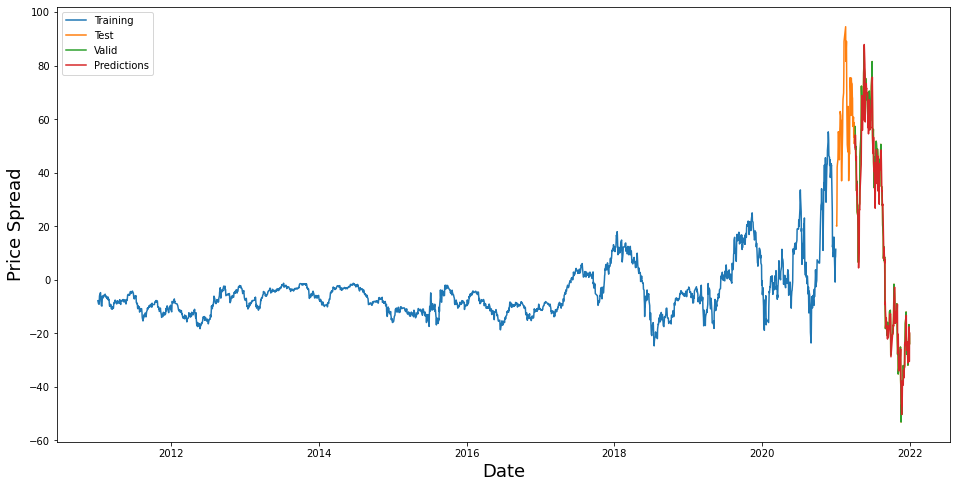

In [101]:
valid = df_test_spread.filter(['sz000858-sz000596'])[60:]
valid['Predictions'] = predictions
valid = pd.merge(
    valid, df_test_spread['date'], left_index=True, right_index=True)

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_train_spread['date'], df_train_spread['sz000858-sz000596'])
plt.plot(df_test_spread['date'], df_test_spread['sz000858-sz000596'])
plt.plot(valid['date'], valid[['sz000858-sz000596', 'Predictions']])
plt.legend(['Training', 'Test', 'Valid', 'Predictions'])

### Описание трейдинговой стратегии

Как указано в статье [1], трейдинговая стратегия реализуется с использованием исторического среднего по ценовому спреду двух акций и интервалом в +-1.5 стандартных отклонения. Построим такой интервал:

In [102]:
df_res.date.max()

Timestamp('2022-05-11 00:00:00')

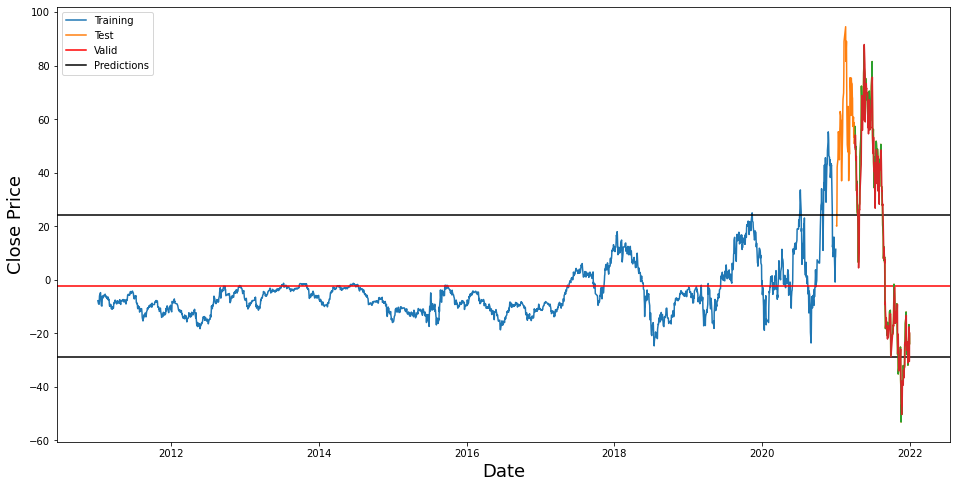

In [103]:
valid = df_test_spread.filter(['sz000858-sz000596'])[60:]
valid['Predictions'] = predictions
valid = pd.merge(
    valid, df_test_spread['date'], left_index=True, right_index=True)

plt.figure(figsize=(16, 8))
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df_train_spread['date'], df_train_spread['sz000858-sz000596'])
plt.plot(df_test_spread['date'], df_test_spread['sz000858-sz000596'])
plt.axhline(np.mean(df_spread_all['sz000858-sz000596']), color='red')
plt.axhline(np.mean(df_spread_all['sz000858-sz000596'])+1.5 *
            np.std(df_spread_all['sz000858-sz000596']), color='black')
plt.axhline(np.mean(df_spread_all['sz000858-sz000596'])-1.5 *
            np.std(df_spread_all['sz000858-sz000596']), color='black')
plt.plot(valid['date'], valid[['sz000858-sz000596', 'Predictions']])
plt.legend(['Training', 'Test', 'Valid', 'Predictions'])

Делаем вывод о том, что в случае выбранных акций необходимо использовать moving average:

In [104]:
spread_mavg60 = df_spread_all['sz000858-sz000596'].rolling(window=60,
                                                           center=False).mean()

std_60 = df_spread_all['sz000858-sz000596'].rolling(window=60,
                                                    center=False).std()

Для демонстрации покажем, как это выглядить на всем временом промежутке:

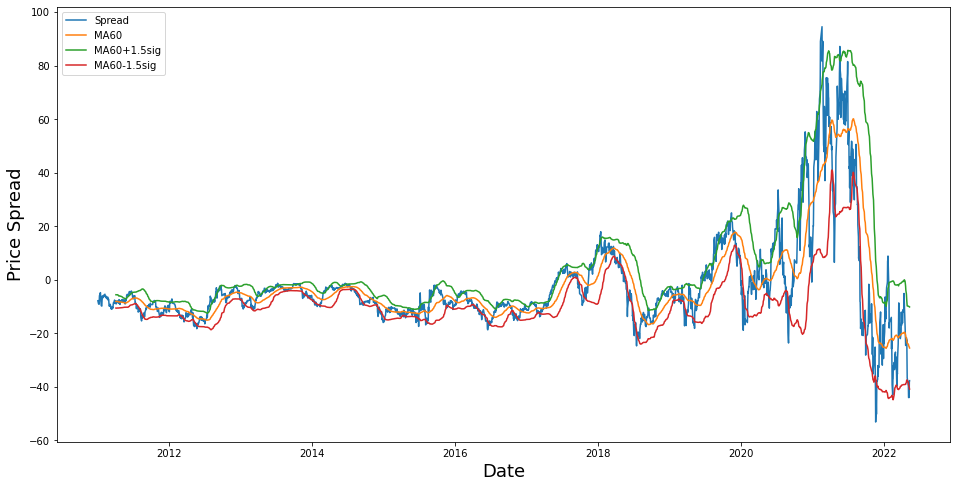

In [105]:
plt.figure(figsize=(16, 8))
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_spread_all['date'], df_spread_all['sz000858-sz000596'])
plt.plot(df_spread_all['date'], spread_mavg60)
plt.plot(df_spread_all['date'], spread_mavg60+1.5*std_60)
plt.plot(df_spread_all['date'], spread_mavg60-1.5*std_60)
plt.legend(['Spread', 'MA60', 'MA60+1.5sig', 'MA60-1.5sig'])

## Применение трейдинговой стратегии

### Демонстрация на обучающей выборке

Продемонстрируем, как работает стратегия на обучающей выборке:

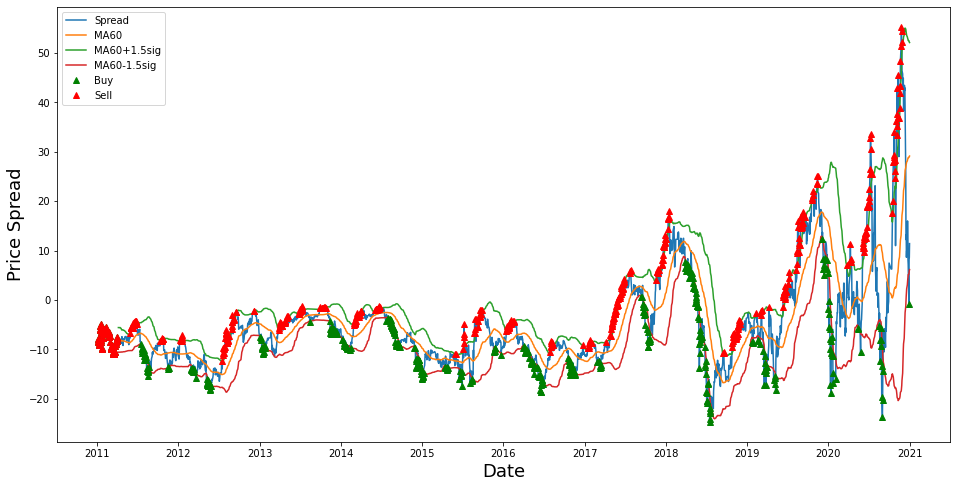

In [106]:
buy = df_train_spread['sz000858-sz000596'].copy()
sell = df_train_spread['sz000858-sz000596'].copy()
buy[df_train_spread['sz000858-sz000596'] >
    spread_mavg60[:len(df_train_spread)]-1.5*std_60[:len(df_train_spread)]] = 0
sell[df_train_spread['sz000858-sz000596'] <
     spread_mavg60[:len(df_train_spread)]+1.5*std_60[:len(df_train_spread)]] = 0

plt.figure(figsize=(16, 8))

plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_train_spread['date'], df_train_spread['sz000858-sz000596'])
plt.plot(df_train_spread['date'], spread_mavg60[:len(df_train_spread)])
plt.plot(df_train_spread['date'], spread_mavg60[:len(
    df_train_spread)]+1.5*std_60[:len(df_train_spread)])
plt.plot(df_train_spread['date'], spread_mavg60[:len(
    df_train_spread)]-1.5*std_60[:len(df_train_spread)])
plt.plot(buy[buy != 0].to_frame().merge(df_train_spread.date, left_index=True,
         right_index=True).date, buy[buy != 0], color='g', linestyle='None', marker='^')
plt.plot(sell[sell != 0].to_frame().merge(df_train_spread.date, left_index=True,
         right_index=True).date, sell[sell != 0], color='r', linestyle='None', marker='^')
plt.legend(['Spread', 'MA60', 'MA60+1.5sig', 'MA60-1.5sig', 'Buy', 'Sell'])

Посчитаем коэффициент шарпа и отношение накопленной доходности к максимальной просадке на обучающей выборке:

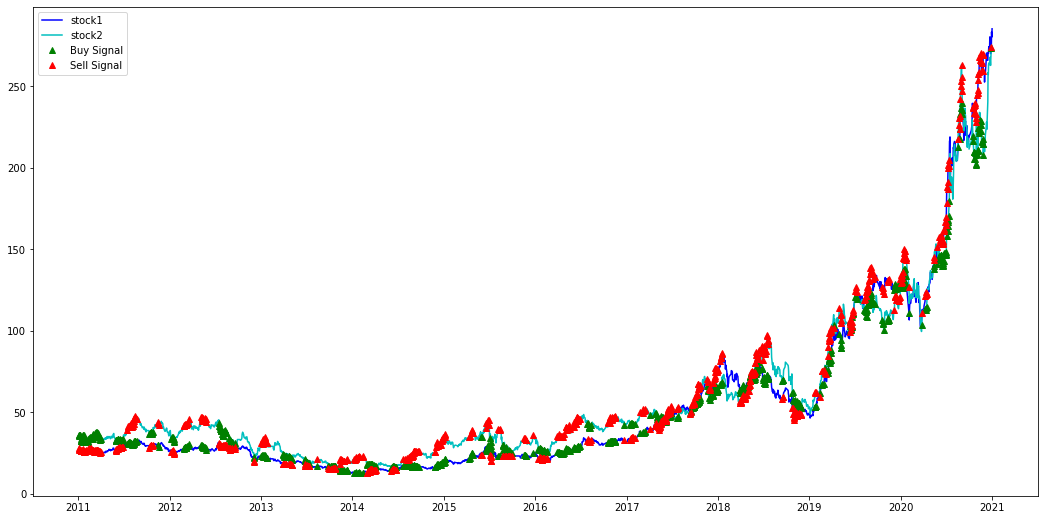

In [107]:
plt.figure(figsize=(18, 9))
S1 = df_train['sz000858'][:]
S2 = df_train['sz000596'][:]

plt.plot(df_train['date'], S1, color='b')
plt.plot(df_train['date'], S2, color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy != 0] = S1[buy != 0]
s1_buy_sell[sell != 0] = S1[sell != 0]*-1

s2_buy_sell[buy != 0] = S2[buy != 0]*-1
s2_buy_sell[sell != 0] = S2[sell != 0]

buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]

buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

plt.plot(buyR[buyR != 0].to_frame().merge(df_train['date'], left_index=True,
         right_index=True).date, buyR[buyR != 0], color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR != 0].to_frame().merge(df_train['date'], left_index=True,
         right_index=True).date, sellR[sellR != 0], color='r', linestyle='None', marker='^')

plt.legend(['stock1', 'stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [108]:
money = 500000
s1_num = 8654
s2_num = 7200
portfolio = [s1_num*S1[0]+S2[0]*s2_num+money]
commision = 1e-4

In [109]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']
for i in range(len(buy_sell)):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)

In [110]:
portfolio_df=pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()

In [111]:
sharpe_ratio = portfolio_df['persentage'][1:].mean()/portfolio_df['persentage'][1:].std()
sharpe_ratio

0.05432782841456418

In [112]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([4.94358087])

In [113]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.3502289848079806

In [114]:
cum_return[0]/Max_DD

14.115281968565242

### Тестовая выборка

На тестовой выборке также продемонстрируем, какой сигнал на покупку и продажу формируется, если вместо тестовых данных использовать предсказанные данные, полученные с использованием LSTM-нейросети (датафрейм valid['Predictions'])

Ниже показан сигнал, сформированный при использовании данных, спрогнозированных LSTM-нейросетью. Для первых 60-ти дней сигнал на покупку и продажу на графике не отображен, так как такое временное окно было использовано в качестве признаков.

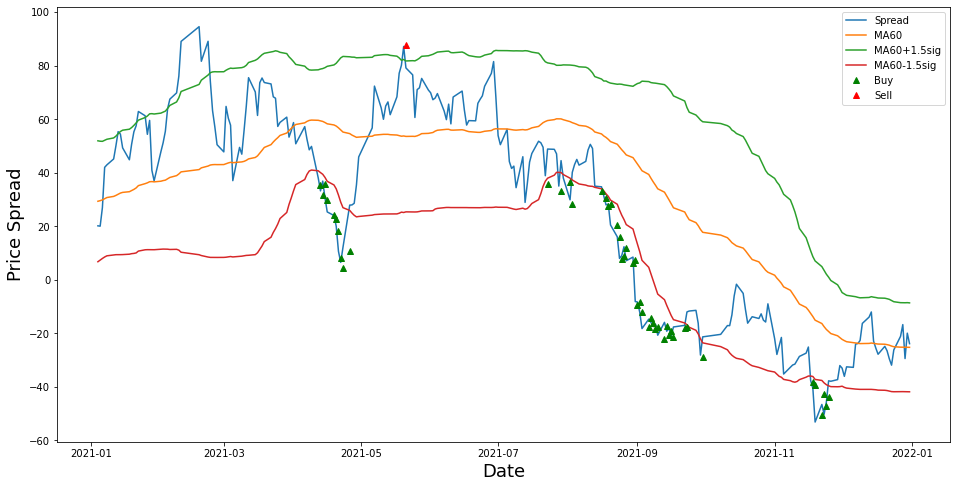

In [115]:
buy = valid['Predictions'].copy()
sell = valid['Predictions'].copy()
buy[valid['Predictions'] > spread_mavg60[len(df_train_spread)+60:len(df_train_spread)+len(
    df_test_spread)]-1.5*std_60[len(df_train_spread)+60:len(df_train_spread)+len(df_test_spread)]] = 0
sell[valid['Predictions'] < spread_mavg60[len(df_train_spread)+60:len(df_train_spread)+len(
    df_test_spread)]+1.5*std_60[len(df_train_spread)+60:len(df_train_spread)+len(df_test_spread)]] = 0

plt.figure(figsize=(16, 8))

plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_test_spread['date'], df_test_spread['sz000858-sz000596'])
plt.plot(df_test_spread['date'], spread_mavg60[len(
    df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(df_test_spread['date'], spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]+1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(df_test_spread['date'], spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]-1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(buy[buy != 0].to_frame().merge(df_test_spread.date, left_index=True,
         right_index=True).date, buy[buy != 0], color='g', linestyle='None', marker='^')
plt.plot(sell[sell != 0].to_frame().merge(df_test_spread.date, left_index=True,
         right_index=True).date, sell[sell != 0], color='r', linestyle='None', marker='^')
plt.legend(['Spread', 'MA60', 'MA60+1.5sig', 'MA60-1.5sig', 'Buy', 'Sell'])

Ниже то, как формируется сигнал на тестовых данных:

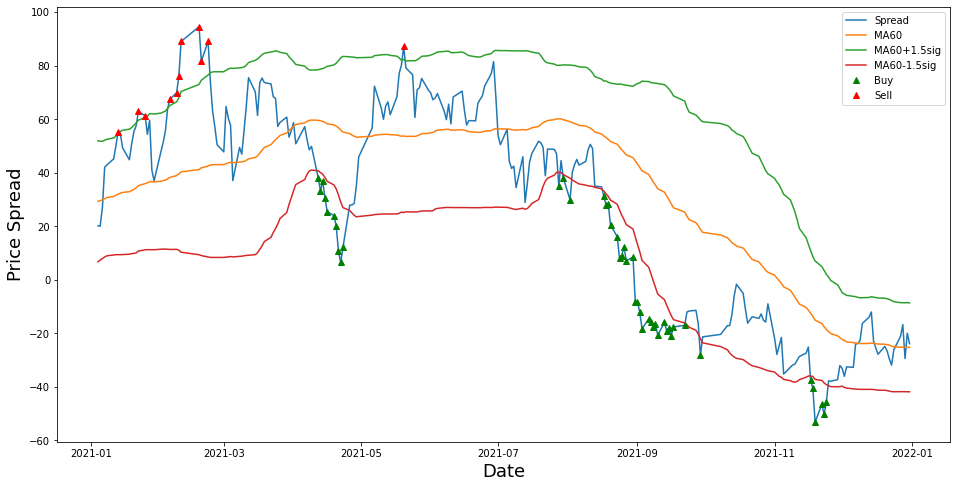

In [116]:
buy = df_test_spread['sz000858-sz000596'].copy()
sell = df_test_spread['sz000858-sz000596'].copy()
buy[df_test_spread['sz000858-sz000596'] > spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]-1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)]] = 0
sell[df_test_spread['sz000858-sz000596'] < spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]+1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)]] = 0

plt.figure(figsize=(16, 8))

plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_test_spread['date'], df_test_spread['sz000858-sz000596'])
plt.plot(df_test_spread['date'], spread_mavg60[len(
    df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(df_test_spread['date'], spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]+1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(df_test_spread['date'], spread_mavg60[len(df_train_spread):len(df_train_spread)+len(
    df_test_spread)]-1.5*std_60[len(df_train_spread):len(df_train_spread)+len(df_test_spread)])
plt.plot(buy[buy != 0].to_frame().merge(df_test_spread.date, left_index=True,
         right_index=True).date, buy[buy != 0], color='g', linestyle='None', marker='^')
plt.plot(sell[sell != 0].to_frame().merge(df_test_spread.date, left_index=True,
         right_index=True).date, sell[sell != 0], color='r', linestyle='None', marker='^')
plt.legend(['Spread', 'MA60', 'MA60+1.5sig', 'MA60-1.5sig', 'Buy', 'Sell'])

Ниже показан сигнал, сформированный при использовании данных, спрогнозированных LSTM-нейросетью. Для первых 60-ти дней сигнал на покупку и продажу на графике не отображен, так как такое временное окно было использовано в качестве признаков.

Сопоставляя два графика, можно сделать вывод о том, что применение LSTM-нейросети оправдано, и сигнал на покупку и продажу формируется правильно.

Далее посчитаем показатели торговой стратегии (как делали и на обучающей выборке)

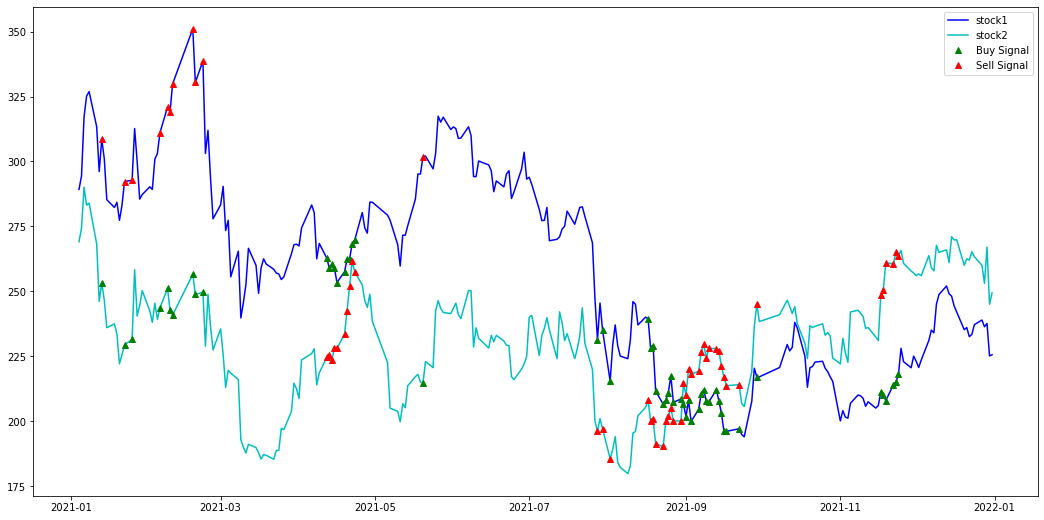

In [117]:
plt.figure(figsize=(18,9))
S1 = df_test['sz000858'][:]
S2 = df_test['sz000596'][:]

plt.plot(df_test['date'],S1, color='b')
plt.plot(df_test['date'],S2, color='c')
buyR = 0*S1.copy()
sellR  = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy!=0] = S1[buy!=0]
s1_buy_sell[sell!=0] = S1[sell!=0]*-1

s2_buy_sell[buy!=0] = S2[buy!=0]*-1
s2_buy_sell[sell!=0] = S2[sell!=0]

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

plt.plot(buyR[buyR!=0].to_frame().merge(df_test['date'],left_index=True,right_index=True).date,buyR[buyR!=0],color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR!=0].to_frame().merge(df_test['date'],left_index=True,right_index=True).date,sellR[sellR!=0],color='r', linestyle='None', marker='^')
plt.legend(['stock1','stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [118]:
money = 500267.61
s1_num = 887
s2_num = 904
portfolio = [s1_num*S1[len(df_train)]+S2[len(df_train)]*s2_num+money]
commision = 1e-4

In [119]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']

In [120]:
for i in range(len(df_train),len(df_train)+len(df_test)):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)

portfolio_df=pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
portfolio_df[1:]

,Portfolio,persentage
1,1.000000e+06,0.000000
2,1.009332e+06,0.009332
3,1.043777e+06,0.034126
4,1.044652e+06,0.000838
5,1.046910e+06,0.002161
...,...,...
239,9.473592e+05,-0.001280
240,9.388920e+05,-0.008938
241,9.522248e+05,0.014201
242,9.215630e+05,-0.032200


In [121]:
portfolio_df = pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
portfolio_df['persentage'][1:]
sharpe_ratio = portfolio_df['persentage'][1:].mean(
)/portfolio_df['persentage'][1:].std()
sharpe_ratio

-0.01602925793176673

In [122]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([0.92576149])

In [123]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.18250082773521448

In [124]:
cum_return[0]/Max_DD

5.072642669742643

### Посчитаем показатели торговой стратегии на результирующей выборке

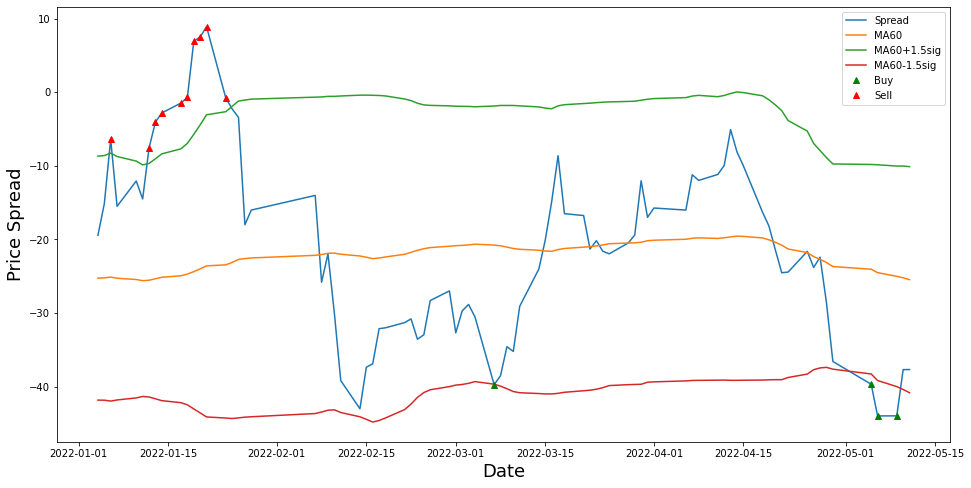

In [125]:
len_1 = len(df_train_spread)+len(df_test_spread)
len_2 = len_1 + len(df_res_spread)
buy = df_res_spread['sz000858-sz000596'].copy()
sell = df_res_spread['sz000858-sz000596'].copy()
buy[df_res_spread['sz000858-sz000596'] >
    spread_mavg60[len_1:len_2]-1.5*std_60[len_1:len_2]] = 0
sell[df_res_spread['sz000858-sz000596'] <
     spread_mavg60[len_1:len_2]+1.5*std_60[len_1:len_2]] = 0

plt.figure(figsize=(16, 8))

plt.xlabel('Date',  fontsize=18)
plt.ylabel('Price Spread', fontsize=18)
plt.plot(df_res_spread['date'], df_res_spread['sz000858-sz000596'])
plt.plot(df_res_spread['date'], spread_mavg60[len_1:len_2])
plt.plot(df_res_spread['date'],
         spread_mavg60[len_1:len_2]+1.5*std_60[len_1:len_2])
plt.plot(df_res_spread['date'],
         spread_mavg60[len_1:len_2]-1.5*std_60[len_1:len_2])
plt.plot(buy[buy != 0].to_frame().merge(df_res_spread.date, left_index=True,
         right_index=True).date, buy[buy != 0], color='g', linestyle='None', marker='^')
plt.plot(sell[sell != 0].to_frame().merge(df_res_spread.date, left_index=True,
         right_index=True).date, sell[sell != 0], color='r', linestyle='None', marker='^')
plt.legend(['Spread', 'MA60', 'MA60+1.5sig', 'MA60-1.5sig', 'Buy', 'Sell'])

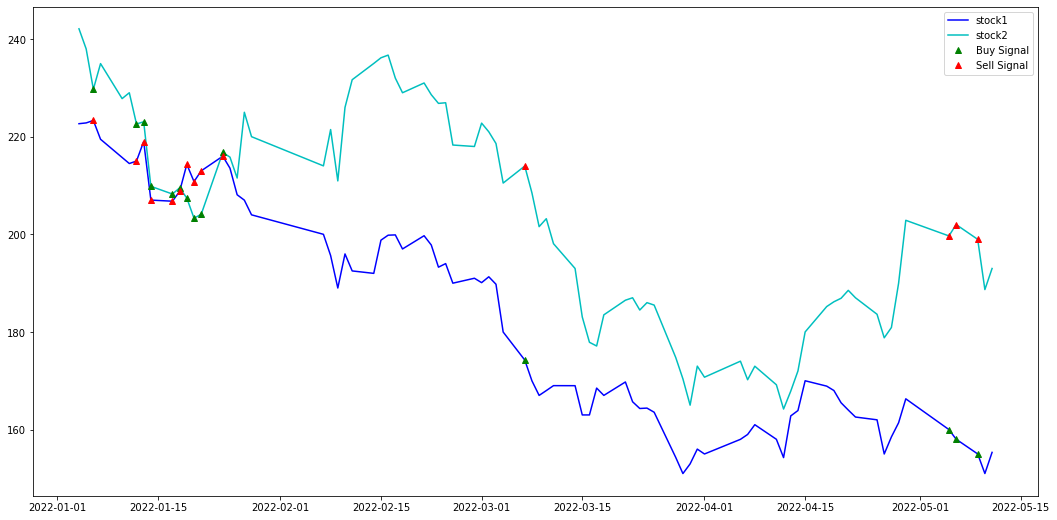

In [126]:
plt.figure(figsize=(18,9))
S1 = df_res['sz000858'][:]
S2 = df_res['sz000596'][:]

plt.plot(df_res['date'],S1, color='b')
plt.plot(df_res['date'],S2, color='c')
buyR = 0*S1.copy()
sellR  = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy!=0] = S1[buy!=0]
s1_buy_sell[sell!=0] = S1[sell!=0]*-1

s2_buy_sell[buy!=0] = S2[buy!=0]*-1
s2_buy_sell[sell!=0] = S2[sell!=0]

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

plt.plot(buyR[buyR!=0].to_frame().merge(df_res['date'],left_index=True,right_index=True).date,buyR[buyR!=0],color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR!=0].to_frame().merge(df_res['date'],left_index=True,right_index=True).date,sellR[sellR!=0],color='r', linestyle='None', marker='^')
plt.legend(['stock1','stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [127]:
money = 499881.16
s1_num = 1099
s2_num = 1055
portfolio = [s1_num*S1[len(df_train)+len(df_test)]+S2[len(df_train)+len(df_test)]*s2_num+money]
commision = 1e-4
portfolio

[1000000.0]

In [128]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']
df_test
for i in range(len_1, len_2):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)

portfolio_df = pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()

In [129]:
portfolio_df=pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
portfolio_df['persentage'][1:]
sharpe_ratio = portfolio_df['persentage'][1:].mean()/portfolio_df['persentage'][1:].std()
sharpe_ratio

-0.15763509971498363

In [130]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([0.87459612])

In [131]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.157782765682

In [132]:
cum_return[0]/Max_DD

5.543039590982237

Как мы видим, с учетом изменения цены акций во времени, на тестовом и результирующем временных промежутках результаты неудовлетворительные. Попробуем оптимизировать стратегию.

## Оптимизация стратегии

Попробуем использовать не спред в абсолютных значениях, а возьмем отношение двух ценовых рядов и стандартизируем это отношение (z_score оценка). Ориентируемся на статью [5] (раздел z-score)

### Обучающая выборка

In [203]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [204]:
S1 = df_prices['sz000858'][:]
S2 = df_prices['sz000596'][:]
ratios = S1 / S2

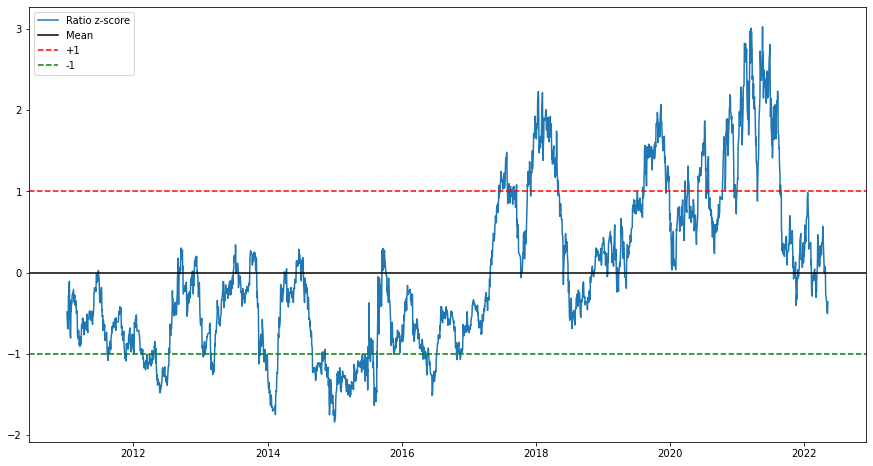

In [205]:
plt.figure(figsize=(15,8))
plt.plot(df_prices['date'],zscore(ratios))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

Также разобьем на выборки как изначально требовалось в задании:

In [210]:
ratios_train = ratios[0:len(df_train)]
ratios_test = ratios[len(df_train):len(df_train)+len(df_test)]
ratios_res = ratios[len(df_train)+len(df_test):len(df_train)+len(df_test)+len(df_res)]

Также попробуем добавить скользящие средние, чтобы статистики учитывали значительное изменений цены акций во времени. В качестве среднего значения также воспользуемся скользящим средним с окном в 60 дней, как делали до этого:

In [211]:
ratios_mavg60 = ratios_train.rolling(window=60,
                               center=False).mean()

std_60 = ratios_train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_train - ratios_mavg60)/std_60

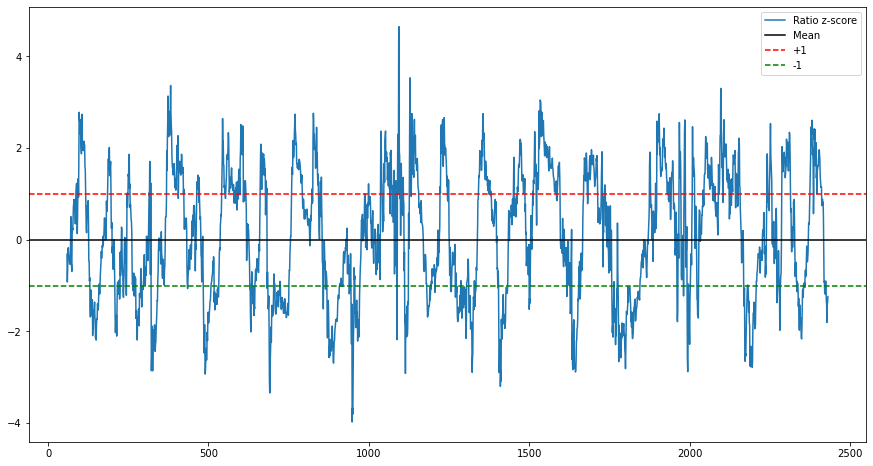

In [212]:
plt.figure(figsize=(15,8))
plt.plot(zscore_60_5)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

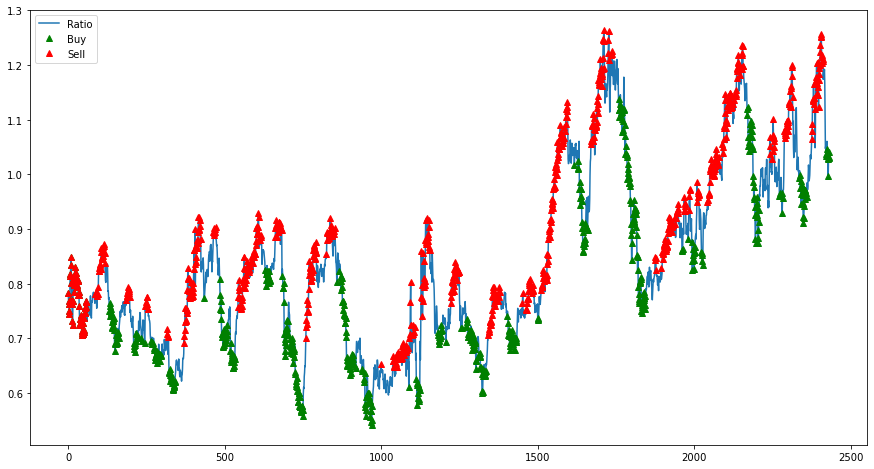

In [162]:
plt.figure(figsize=(15,8))
plt.plot(ratios_train)
buy = ratios_train.copy()
sell = ratios_train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
plt.plot(buy[buy!=0],color='g', linestyle='None', marker='^')
plt.plot(sell[sell!=0],color='r', linestyle='None', marker='^')
plt.legend(['Ratio', 'Buy', 'Sell'])
plt.show()

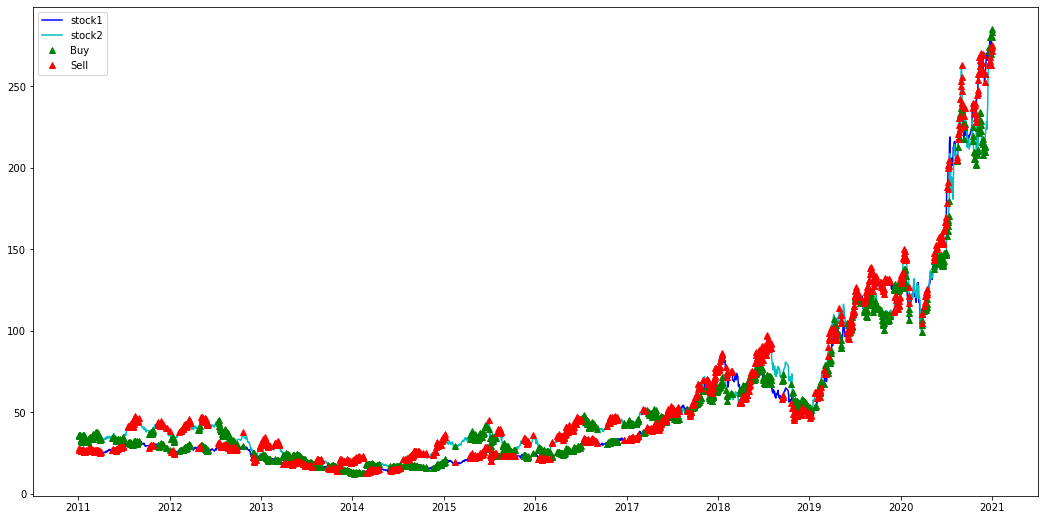

In [163]:
plt.figure(figsize=(18,9))
S1 = df_train['sz000858'][:]
S2 = df_train['sz000596'][:]

plt.plot(df_train['date'],S1, color='b')
plt.plot(df_train['date'],S2, color='c')
buyR = 0*S1.copy()
sellR  = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy!=0] = S1[buy!=0]
s1_buy_sell[sell!=0] = S1[sell!=0]*-1

s2_buy_sell[buy!=0] = S2[buy!=0]*-1
s2_buy_sell[sell!=0] = S2[sell!=0]

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

plt.plot(buyR[buyR!=0].to_frame().merge(df_train['date'],left_index=True,right_index=True).date,buyR[buyR!=0],color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR!=0].to_frame().merge(df_train['date'],left_index=True,right_index=True).date,sellR[sellR!=0],color='r', linestyle='None', marker='^')
plt.legend(['stock1','stock2', 'Buy', 'Sell'])
plt.show()

In [164]:
money = 500000
s1_num = 8654
s2_num = 7200
portfolio = [s1_num*S1[0]+S2[0]*s2_num+money]
commision = 1e-4
portfolio

[1000000.0]

In [165]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']
for i in range(len(buy_sell)):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)
portfolio_df=pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
portfolio_df

,Portfolio,persentage
0,1.000000e+06,NaN
1,1.000000e+06,-6.379000e-09
2,9.978065e+05,-2.193476e-03
3,9.888413e+05,-8.984955e-03
4,9.906843e+05,1.863872e-03
...,...,...
2428,4.732029e+06,-9.796371e-03
2429,4.845261e+06,2.392871e-02
2430,4.936632e+06,1.885778e-02
2431,4.883126e+06,-1.083839e-02


In [166]:
sharpe_ratio = portfolio_df['persentage'][1:].mean()/portfolio_df['persentage'][1:].std()
sharpe_ratio

0.05429827963255926

In [167]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([4.94286191])

In [168]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.34988210994129

In [169]:
cum_return[0]/Max_DD

14.127221040293854

### тестовая выборка

In [172]:
ratios_mavg60 = ratios_test.rolling(window=60,
                               center=False).mean()

std_60 = ratios_test.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_test - ratios_mavg60)/std_60

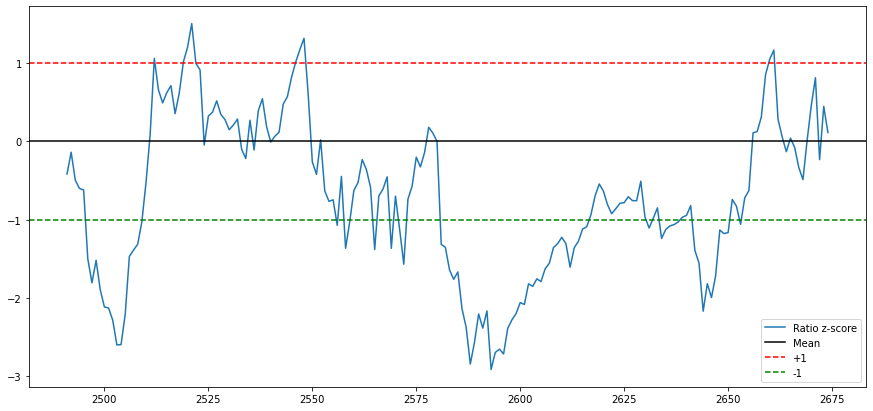

In [173]:
plt.figure(figsize=(15,7))
plt.plot(zscore_60_5)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

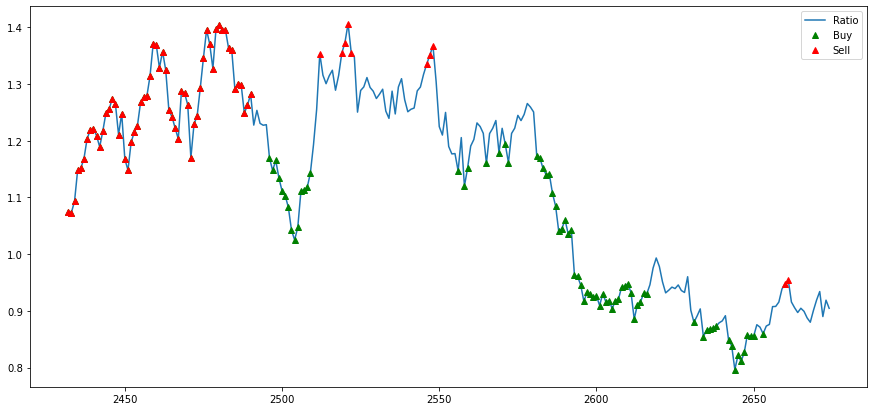

In [175]:
plt.figure(figsize=(15,7))
plt.plot(ratios_test)
buy = ratios_test.copy()
sell = ratios_test.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
plt.plot(buy[buy!=0],color='g', linestyle='None', marker='^')
plt.plot(sell[sell!=0],color='r', linestyle='None', marker='^')
plt.legend(['Ratio', 'Buy', 'Sell'])
plt.show()

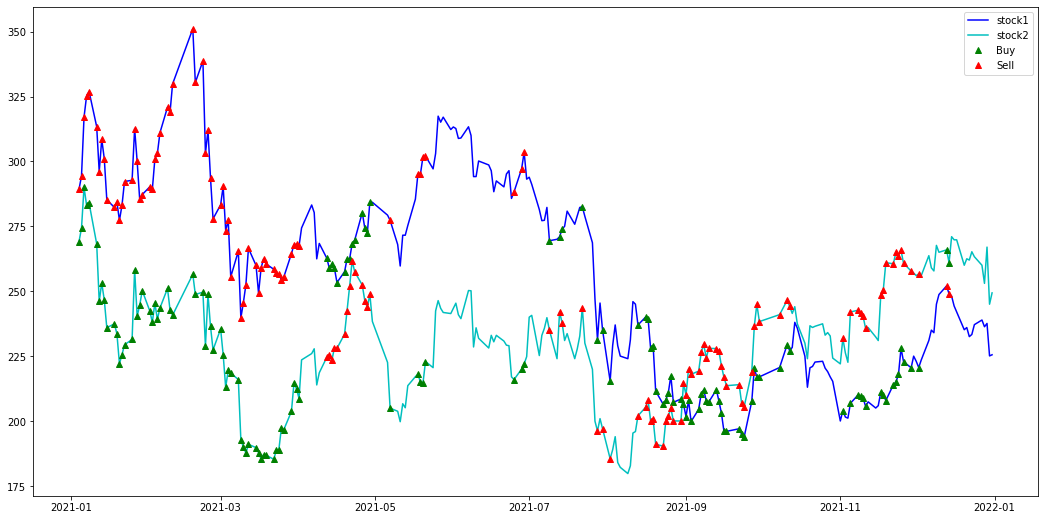

In [176]:
plt.figure(figsize=(18, 9))
S1 = df_test['sz000858'][:]
S2 = df_test['sz000596'][:]

plt.plot(df_test['date'], S1, color='b')
plt.plot(df_test['date'], S2, color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy != 0] = S1[buy != 0]
s1_buy_sell[sell != 0] = S1[sell != 0]*-1

s2_buy_sell[buy != 0] = S2[buy != 0]*-1
s2_buy_sell[sell != 0] = S2[sell != 0]

buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]

buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

plt.plot(buyR[buyR != 0].to_frame().merge(df_test['date'], left_index=True,
         right_index=True).date, buyR[buyR != 0], color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR != 0].to_frame().merge(df_test['date'], left_index=True,
         right_index=True).date, sellR[sellR != 0], color='r', linestyle='None', marker='^')
plt.legend(['stock1', 'stock2', 'Buy', 'Sell'])
plt.show()

In [177]:
money = 500267.61
s1_num = 887
s2_num = 904
portfolio = [s1_num*S1[len(df_train)]+S2[len(df_train)]*s2_num+money]
commision = 1e-4

In [178]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']
df_test
for i in range(len(df_train), len(df_train)+len(df_test)):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                       abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)

portfolio_df = pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
portfolio_df[1:]

,Portfolio,persentage
1,9.999999e+05,-5.582400e-08
2,1.009332e+06,9.332194e-03
3,1.043763e+06,3.411245e-02
4,1.044593e+06,7.951415e-04
5,1.046847e+06,2.157710e-03
...,...,...
239,9.513229e+05,-1.433952e-03
240,9.427243e+05,-9.038571e-03
241,9.564378e+05,1.454665e-02
242,9.254914e+05,-3.235590e-02


In [179]:
sharpe_ratio = portfolio_df['persentage'][1:].mean()/portfolio_df['persentage'][1:].std()
sharpe_ratio

-0.014749512319921547

In [180]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([0.92980745])

In [181]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.18039567477536012

In [190]:
cum_return[0]/Max_DD

5.154266866314035

### Результирующая выборка

In [191]:
ratios_mavg60 = ratios_res.rolling(window=60,
                                   center=False).mean()

std_60 = ratios_res.rolling(window=60,
                            center=False).std()

zscore_60_5 = (ratios_res - ratios_mavg60)/std_60

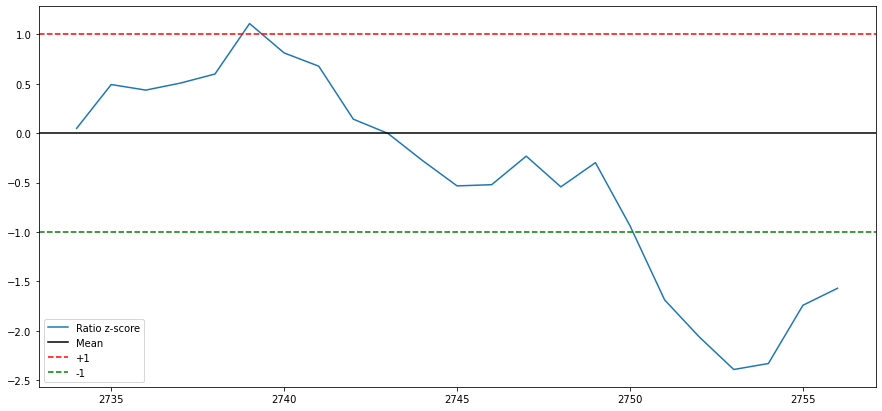

In [192]:
plt.figure(figsize=(15, 7))
plt.plot(zscore_60_5)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

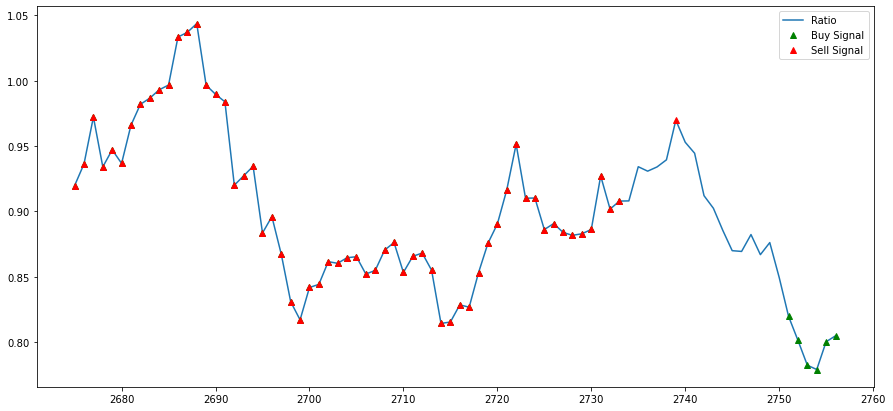

In [193]:
plt.figure(figsize=(15, 7))
plt.plot(ratios_res)
buy = ratios_res.copy()
sell = ratios_res.copy()
buy[zscore_60_5 > -1] = 0
sell[zscore_60_5 < 1] = 0
plt.plot(buy[buy != 0], color='g', linestyle='None', marker='^')
plt.plot(sell[sell != 0], color='r', linestyle='None', marker='^')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

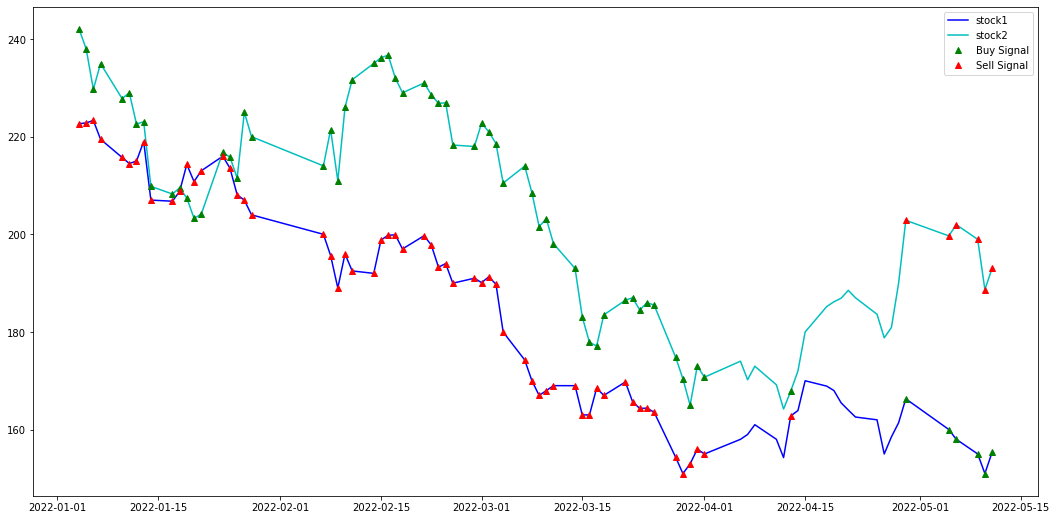

In [194]:
plt.figure(figsize=(18, 9))
S1 = df_res['sz000858'][:]
S2 = df_res['sz000596'][:]

plt.plot(df_res['date'], S1, color='b')
plt.plot(df_res['date'], S2, color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
s1_buy_sell = 0*S1.copy()
s2_buy_sell = 0*S1.copy()

s1_buy_sell[buy != 0] = S1[buy != 0]
s1_buy_sell[sell != 0] = S1[sell != 0]*-1

s2_buy_sell[buy != 0] = S2[buy != 0]*-1
s2_buy_sell[sell != 0] = S2[sell != 0]

buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]

buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

plt.plot(buyR[buyR != 0].to_frame().merge(df_res['date'], left_index=True,
         right_index=True).date, buyR[buyR != 0], color='g', linestyle='None', marker='^')
plt.plot(sellR[sellR != 0].to_frame().merge(df_res['date'], left_index=True,
         right_index=True).date, sellR[sellR != 0], color='r', linestyle='None', marker='^')
plt.legend(['stock1', 'stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [195]:
money = 499881.16
s1_num = 1099
s2_num = 1055
portfolio = [s1_num*S1[len(df_train)+len(df_test)]+S2[len(df_train)+len(df_test)]*s2_num+money]
commision = 1e-4
portfolio

[1000000.0]

In [196]:
buy_sell = pd.DataFrame(s1_buy_sell).merge(
    pd.DataFrame(s2_buy_sell), left_index=True, right_index=True)
buy_sell.columns = ['s1_buy_sell', 's2_buy_sell']
df_test
for i in range(len_1,len_2):
    if (buy_sell['s1_buy_sell'][i] < 0) and (buy_sell['s2_buy_sell'][i] > 0):
        s1_num = s1_num-1
        s2_num = s2_num+1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    if (buy_sell['s1_buy_sell'][i] > 0) and (buy_sell['s2_buy_sell'][i] < 0):
        s1_num = s1_num+1
        s2_num = s2_num-1
        money = money - buy_sell['s1_buy_sell'][i] - buy_sell['s2_buy_sell'][i] - \
            commision*(abs(buy_sell['s1_buy_sell'][i]) +
                        abs(buy_sell['s2_buy_sell'][i]))
    portfolio.append(s1_num*S1[i]+S2[i]*s2_num+money)

portfolio_df=pd.DataFrame(portfolio, columns=['Portfolio'])
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()

In [197]:
portfolio_df['persentage'] = portfolio_df['Portfolio'].pct_change(1).dropna()
sharpe_ratio = portfolio_df['persentage'][1:].mean()/portfolio_df['persentage'][1:].std()
sharpe_ratio

-0.15570991434755804

In [198]:
cumulative_ret = (portfolio_df['persentage'][1:] + 1).cumprod()
cum_return = cumulative_ret.values[-1:]
cum_return

array([0.87528748])

In [199]:
Roll_Max = portfolio_df['Portfolio'][1:].cummax()
Drawdown = portfolio_df['Portfolio'][1:]/Roll_Max - 1.0
Max_Daily_Drawdown = Drawdown.cummin()
Max_DD = abs(Max_Daily_Drawdown.min())
Max_DD

0.15839598667661203

In [213]:
cum_return[0]/Max_DD

5.525944823141411

## Результаты проделанной работы:
* Проведена предварительная обработка данных
* Рассчитан бета-коэффициент для всех акций, торгуемых на китайском фондовом рынке
* Определена пара акций на основе Augmented Dickey-Fuller теста и коинтеграционного теста
* Проведено моделирование ценового спреда с помощью LSTM-нейросети
* Посчитаны параметры торговой стратегии и сделан вывод о том, что результаты на тестовых и результирующих выборках неудовлетворительны
* Проведена попытка улучшить стратегию путем перехода от спреда в абсолютной величине к стандартизированному отношению ценовых рядов двух акций (z-score оценка)

## Краткие выводы:
* Либо данная торговая стратегия не подходит для использования на резко изменяющемся рынке (период с 2020 года показал неудовлетворительные результаты)
* Либо расчет Коэффициента Шарпа для данной торговой стратегии проведен неправильно, и его нужно пересчитывать другими методами (если это действительно так, то какими именно я на текущий момент ответа не нашел)